In [1]:
from __future__ import print_function

import math
from functools import partial

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.python.data import Dataset

tf.get_logger().setLevel('ERROR')
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [2]:
def preprocess_features(california_housing_dataframe):
  selected_features = california_housing_dataframe[[
    "latitude",
    "longitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income"
  ]]
  
  processed_features = selected_features.copy()
  processed_features["rooms_per_person"] = \
    (california_housing_dataframe["total_rooms"] / california_housing_dataframe['population'])
  return processed_features

In [3]:
def preprocess_targets(california_housing_dataframe):
  output_targets = pd.DataFrame()
  output_targets["median_house_value_is_high"] = \
    (california_housing_dataframe["median_house_value"] > 265000).astype(float)
  return output_targets

In [4]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

In [5]:
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Vlidation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2637.7,539.4,1427.0,501.1,3.9,2.0
std,2.1,2.0,12.5,2164.5,424.9,1123.5,387.2,1.9,1.2
min,32.5,-124.3,2.0,8.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1465.8,296.0,791.8,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2126.0,433.0,1166.0,407.5,3.5,1.9
75%,37.7,-118.0,37.0,3143.2,647.0,1717.0,603.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2657.9,539.5,1435.8,501.6,3.9,2.0
std,2.1,2.0,12.7,2216.7,413.2,1204.5,378.1,1.9,1.1
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1451.8,298.0,783.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2133.5,437.0,1168.0,412.0,3.6,1.9
75%,37.7,-118.0,37.0,3165.2,652.0,1728.2,608.0,4.8,2.3
max,42.0,-114.5,52.0,30401.0,4957.0,35682.0,4769.0,15.0,52.0


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Vlidation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.2
max,1.0


In [6]:
training_targets[['median_house_value_is_high']]

,median_house_value_is_high
1888,0.0
6907,0.0
8668,1.0
4477,0.0
467,1.0
...,...
15639,1.0
368,0.0
3157,0.0
6021,0.0


In [18]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [15]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
  features = {key:np.array(value) for key, value in dict(features).items()}
  
  ds = Dataset.from_tensor_slices((features, targets))
  ds = ds.batch(batch_size).repeat(num_epochs)
  
  if shuffle:
    ds = ds.shuffle(10000)
    
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

In [27]:
def train_linear_regressor_model(
  learning_rate,
  steps,
  batch_size,
  training_examples,
  training_targets,
  validation_examples,
  validation_targets):
  
  periods = 10
  steps_per_period = steps / periods
  
  my_optimizer = partial(optimizers.Ftrl, learning_rate=learning_rate, clipnorm=5.0)
  linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=construct_feature_columns(training_examples),
    optimizer=my_optimizer)
  
  training_input_fn = lambda: my_input_fn(training_examples,
                                          training_targets['median_house_value_is_high'],
                                          batch_size=batch_size)
  
  predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                 training_targets['median_house_value_is_high'],
                                                 num_epochs=1,
                                                 shuffle=False)
  
  predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                   validation_targets['median_house_value_is_high'],
                                                   num_epochs=1,
                                                   shuffle=False)
  
  print("Training model...")
  print("RMSE (on training data)")
  
  training_rmse = []
  validation_rmse = []
  
  for period in range(0, periods):
    linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
    
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
    
    print(" period %d :  %f" % (period, training_root_mean_squared_error))
    
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
    
  print("Model training finished.")
  
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label='training')
  plt.plot(validation_rmse, label='validation')
  plt.legend()
  
  return linear_regressor 

Training model...
RMSE (on training data)
 period 0 :  0.480415
 period 1 :  0.473342
 period 2 :  0.469204
 period 3 :  0.467084
 period 4 :  0.464547
 period 5 :  0.462400
 period 6 :  0.460041
 period 7 :  0.458823
 period 8 :  0.457662
 period 9 :  0.456407
Model training finished.


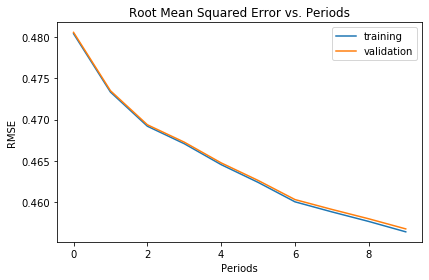

In [28]:
linear_regressor = train_linear_regressor_model(
  learning_rate=0.000001,
  steps=200,
  batch_size=20,
  training_examples=training_examples,
  training_targets=training_targets,
  validation_examples=validation_examples,
  validation_targets=validation_targets)

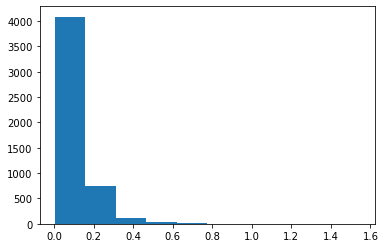

In [29]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

_ = plt.hist(validation_predictions)